# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:05<00:00, 11.9KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/daniel/anaconda3/envs/dl/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


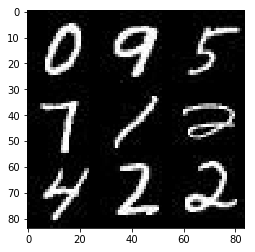

In [2]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

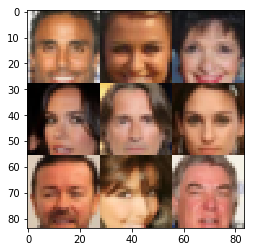

In [3]:
show_n_images = 10

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_inputs")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return real_inputs, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/daniel/anaconda3/envs/dl/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/daniel/anaconda3/envs/dl/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/daniel/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/daniel/anaconda3/envs/dl/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/daniel/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/daniel/anaconda3/e

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
            # Input layer is 32x32x3
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(.2 * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(.2 * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(.2 * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(.1 * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(.1 * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(.1 * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
#     saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0
    
    if data_image_mode == 'RGB':
        out_channel_dim = 3
    else:
        out_channel_dim = 1
        
    real_images, z_inputs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_images, z_inputs, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                
                _ = sess.run(d_train_opt, feed_dict={real_images: batch_images, z_inputs: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_inputs: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_images: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_inputs, out_channel_dim, data_image_mode)

#         saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses, samples
                
                

In [14]:
!mkdir checkpoints

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3435... Generator Loss: 1.4760
Epoch 1/2... Discriminator Loss: 0.0062... Generator Loss: 5.3386
Epoch 1/2... Discriminator Loss: 0.0036... Generator Loss: 8.1267
Epoch 1/2... Discriminator Loss: 0.0946... Generator Loss: 5.0710
Epoch 1/2... Discriminator Loss: 0.2142... Generator Loss: 3.6382
Epoch 1/2... Discriminator Loss: 0.7874... Generator Loss: 7.5027
Epoch 1/2... Discriminator Loss: 1.3465... Generator Loss: 5.7608
Epoch 1/2... Discriminator Loss: 0.5902... Generator Loss: 1.9042
Epoch 1/2... Discriminator Loss: 1.0644... Generator Loss: 3.1650
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 0.5902


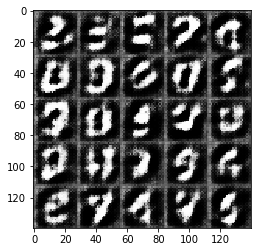

Epoch 1/2... Discriminator Loss: 0.6972... Generator Loss: 1.6100
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 2.4192
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 1.0641
Epoch 1/2... Discriminator Loss: 1.7174... Generator Loss: 0.2915
Epoch 1/2... Discriminator Loss: 0.8553... Generator Loss: 1.0020
Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 0.4116
Epoch 1/2... Discriminator Loss: 1.7333... Generator Loss: 0.2955
Epoch 1/2... Discriminator Loss: 1.4622... Generator Loss: 0.4545
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 0.5017


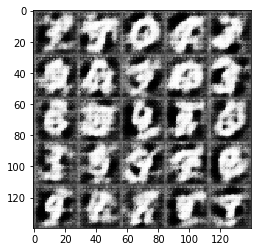

Epoch 1/2... Discriminator Loss: 1.3193... Generator Loss: 2.0949
Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 2.4077
Epoch 1/2... Discriminator Loss: 1.0985... Generator Loss: 1.9618
Epoch 1/2... Discriminator Loss: 0.9567... Generator Loss: 1.0520
Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.4748
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 0.4936
Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 0.5196
Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 0.4716


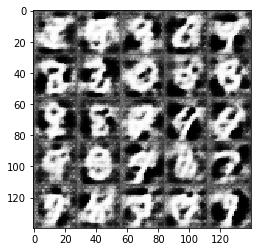

Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 1.8025
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 0.6936
Epoch 1/2... Discriminator Loss: 1.1593... Generator Loss: 1.7464
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 0.9639
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 1.1329
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 1.2499
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 0.9188
Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 1.6848
Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 1.3047
Epoch 1/2... Discriminator Loss: 1.5318... Generator Loss: 0.3604


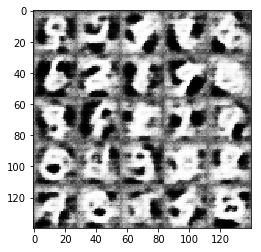

Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.6879
Epoch 1/2... Discriminator Loss: 1.5027... Generator Loss: 0.3616
Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.4397
Epoch 1/2... Discriminator Loss: 1.2661... Generator Loss: 0.5299
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 1.5308... Generator Loss: 0.3599
Epoch 2/2... Discriminator Loss: 1.2471... Generator Loss: 1.1948
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 0.7375
Epoch 2/2... Discriminator Loss: 1.0567... Generator Loss: 0.7447
Epoch 2/2... Discriminator Loss: 1.1189... Generator Loss: 1.2078


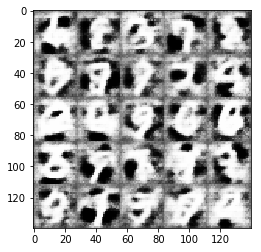

Epoch 2/2... Discriminator Loss: 1.0569... Generator Loss: 0.8159
Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 1.6484
Epoch 2/2... Discriminator Loss: 1.1691... Generator Loss: 1.1959
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 1.1159
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.4483
Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 0.9935
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 1.6666
Epoch 2/2... Discriminator Loss: 1.0501... Generator Loss: 0.9305
Epoch 2/2... Discriminator Loss: 1.0175... Generator Loss: 0.9290
Epoch 2/2... Discriminator Loss: 1.0696... Generator Loss: 0.7370


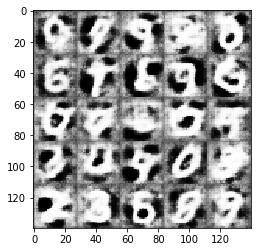

Epoch 2/2... Discriminator Loss: 1.2203... Generator Loss: 0.5017
Epoch 2/2... Discriminator Loss: 1.3958... Generator Loss: 0.3978
Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 1.0562
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.0535... Generator Loss: 1.6601
Epoch 2/2... Discriminator Loss: 1.7287... Generator Loss: 0.2769
Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 1.4485
Epoch 2/2... Discriminator Loss: 1.0301... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 1.4728
Epoch 2/2... Discriminator Loss: 1.0024... Generator Loss: 1.2092


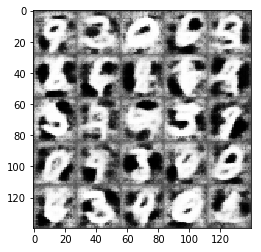

Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 1.4098... Generator Loss: 0.3998
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.4229
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 1.8720
Epoch 2/2... Discriminator Loss: 1.0574... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 1.9187... Generator Loss: 0.2254
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.4653
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.5872
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 0.7580
Epoch 2/2... Discriminator Loss: 1.5026... Generator Loss: 1.8858


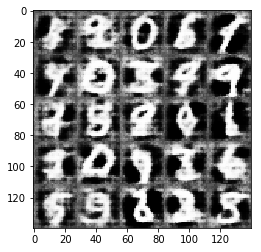

Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 0.5278
Epoch 2/2... Discriminator Loss: 0.9594... Generator Loss: 1.1327
Epoch 2/2... Discriminator Loss: 0.8828... Generator Loss: 1.6777
Epoch 2/2... Discriminator Loss: 1.4893... Generator Loss: 2.3990
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 1.6010
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.4236
Epoch 2/2... Discriminator Loss: 1.5317... Generator Loss: 0.3661
Epoch 2/2... Discriminator Loss: 1.1049... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.0207... Generator Loss: 1.0319
Epoch 2/2... Discriminator Loss: 0.9154... Generator Loss: 1.3547


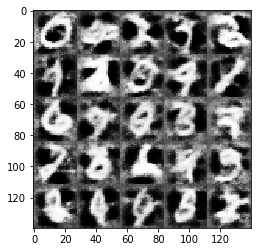

Epoch 2/2... Discriminator Loss: 3.0062... Generator Loss: 3.8608
Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 0.8748
Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 1.4230


In [15]:
batch_size = 128
z_dim = 100
learning_rate = .0005
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

tf.reset_default_graph()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 0.2466... Generator Loss: 2.8447
Epoch 1/1... Discriminator Loss: 1.9830... Generator Loss: 0.3964
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 3.8322
Epoch 1/1... Discriminator Loss: 0.4295... Generator Loss: 3.7610
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 1.4636
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 0.2947... Generator Loss: 2.0047


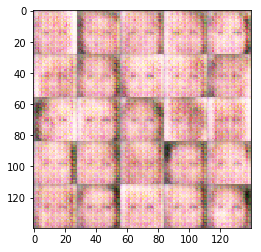

Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 1.5063
Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 3.4402
Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 1.9776
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 4.9064
Epoch 1/1... Discriminator Loss: 1.6642... Generator Loss: 0.3483
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 11.4760
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 1.7665
Epoch 1/1... Discriminator Loss: 2.8442... Generator Loss: 0.0949


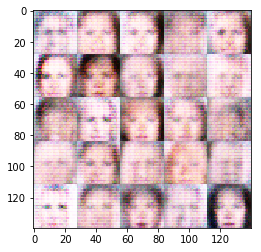

Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.6711
Epoch 1/1... Discriminator Loss: 1.8057... Generator Loss: 0.3255
Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 3.0728
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 1.3556
Epoch 1/1... Discriminator Loss: 2.1129... Generator Loss: 0.2074
Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 5.3835
Epoch 1/1... Discriminator Loss: 0.2629... Generator Loss: 4.7627
Epoch 1/1... Discriminator Loss: 2.0562... Generator Loss: 0.2036
Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 2.0655


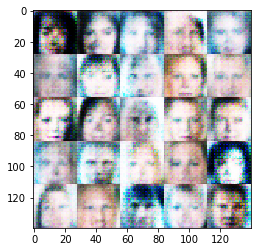

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.6447... Generator Loss: 4.7727
Epoch 1/1... Discriminator Loss: 0.3046... Generator Loss: 3.2571
Epoch 1/1... Discriminator Loss: 0.1560... Generator Loss: 2.8938
Epoch 1/1... Discriminator Loss: 2.2364... Generator Loss: 0.1552
Epoch 1/1... Discriminator Loss: 2.8494... Generator Loss: 0.0825
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.3558
Epoch 1/1... Discriminator Loss: 2.4642... Generator Loss: 0.1250
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.6766


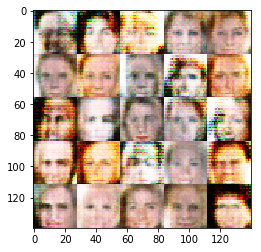

Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.1209
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.3499
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 1.3393
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 3.1714
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 3.4513
Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 1.1766
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.4260
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 1.0390


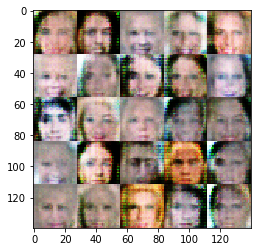

Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.2893
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 2.9745
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 0.5912... Generator Loss: 1.5489
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 1.4337
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.6459... Generator Loss: 0.3180
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 0.9680


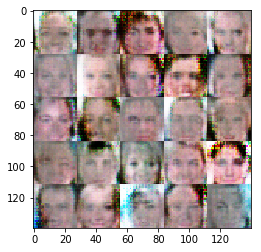

Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 2.5827
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 1.6811
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.0323
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 2.1504


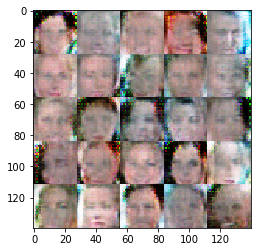

Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 1.4078
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 2.9508
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.3203
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.4951


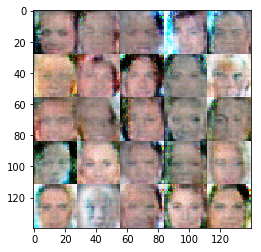

Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 2.2076
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 3.2497
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.3843
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.6581
Epoch 1/1... Discriminator Loss: 0.5477... Generator Loss: 4.5736
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 3.1606
Epoch 1/1... Discriminator Loss: 2.5339... Generator Loss: 2.6534
Epoch 1/1... Discriminator Loss: 0.3830... Generator Loss: 1.7015


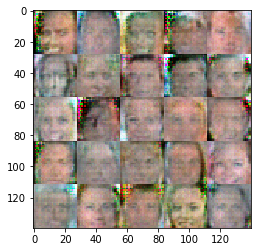

Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 2.1833
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 3.1407
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.2766
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 1.6284
Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 2.1944
Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 1.5719
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.9922
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 1.0719


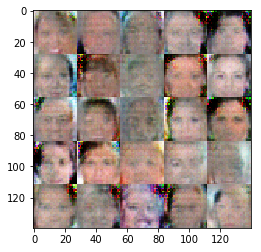

Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.3482
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 2.0580
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 0.2993... Generator Loss: 4.3188
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 0.5245... Generator Loss: 1.2795


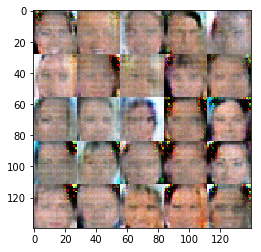

Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.1200
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 3.5151
Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 2.6095
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.3805
Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 1.9061
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 1.5427
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.0356


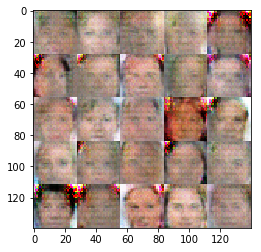

Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 1.5312
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 2.6868
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 1.3866
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 2.3564


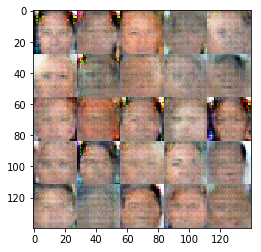

Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.4814
Epoch 1/1... Discriminator Loss: 0.2481... Generator Loss: 2.1150
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 1.9454
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 0.8323... Generator Loss: 0.9604


KeyboardInterrupt: 

In [16]:
batch_size = 128
z_dim = 100
learning_rate = .0005
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.